# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


---
### Why We're Here 

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project. 

![Sample Dog Output](images/sample_dog_output.png)


### The Road Ahead

We break the notebook into separate steps:

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Writing our Algorithm
* [Step 7](#step7): Testing our Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [ ]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


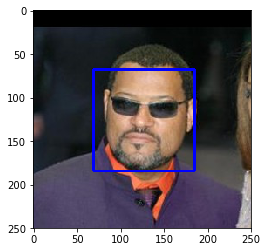

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [24]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.


In [ ]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm on the images in human_files_short and dog_files_short

perc_detected_humans = np.sum([face_detector(f) for f in human_files_short])
print('Percentage of humans with detected face: {}%'.format(perc_detected_humans))
perc_detected_dogs = np.sum([face_detector(f) for f in dog_files_short])
print('Percentage of dogs with detected face: {}%'.format(perc_detected_dogs))

In terms of user experience, having an app that works only with a clear view of the face is not something that we can provide our users with. Indeed, they will try it a few times, see that it is not optimized and will never open it again. On our side however, we could make efforts to build something based on a more 'state-of-the-art' deep learning approach that would eventually be able to detect humans with other features, such as the presence of a head, hair, mouth, neck or the form of the ears.

In [ ]:
# Testing of other haarcascade detectors

lst_xml = [
    'haarcascade_frontalface_alt.xml',
    'haarcascade_eye.xml',
    'haarcascade_upperbody.xml',
    'haarcascade_smile.xml'
]

for xml_ in lst_xml:
    
    face_cascade = cv2.CascadeClassifier('haarcascades/'+xml_)
    
    print('XML used: {}'.format(xml_))
    perc_detected_humans = np.sum([face_detector(f) for f in human_files_short])
    print('   Percentage of humans with detected face: {}%'.format(perc_detected_humans))
    perc_detected_dogs = np.sum([face_detector(f) for f in dog_files_short])
    print('   Percentage of dogs with detected face: {}%'.format(perc_detected_dogs))

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [25]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [26]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [27]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [28]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In [ ]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
perc_detected_humans = np.sum([dog_detector(f) for f in human_files_short])
print('   Percentage of human files with detected dog: {}%'.format(perc_detected_humans))
perc_detected_dogs = np.sum([dog_detector(f) for f in dog_files_short])
print('   Percentage of dog files with detected dog: {}%'.format(perc_detected_dogs))

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.

More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [00:26<00:00, 31.25it/s]


### Model Architecture

Here, we will create a CNN to classify dog breed:

![Sample CNN](images/sample_cnn.png)

At first, I tried the architecture above: it contains a succession of 3 convolutional layers with an increasing number of 2x2 filters, the first one being specified the images input shape provided above (224x224xRGB). Inbetween, in order to reduce dimensionnality, we include MaxPooling layers. After those 6 layers, we can apply either a Flatten() or GlobalAveragePooling2D() layer; the latter does a kind of flatten+averaging operation which allows us to reduce dimensionnality drastically (for computation time purposes). I tried adding a Dropout() layer with a 0.3 probability to reduce overfitting.
We finish with a Dense() layer of 133 nodes (the number of dog classes) activated by a softmax function that determines the probability of an image being in each of the categories.
To my mind, the choice of 3 convolution layers is a good one as they break down quite simply the principal features of the image. 

With these parameters, I achieved a small 5.14% accuracy (which is above 1% but not so great)

In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Defining architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
# model.add(Flatten())
model.add(Dense(133, activation='softmax'))
# model.add(Dropout(0.4))
# model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

We are using model checkpointing to save the model that attains the best validation loss.

In [ ]:
from keras.callbacks import ModelCheckpoint  

### Specifying the number of epochs that we would like to use to train the model

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [25]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Trying out your model on the test dataset of dog images. We need to ensure that our test accuracy is greater than 1%.

In [26]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.1435%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we will train a CNN using transfer learning.

### Obtain Bottleneck Features

In [27]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [28]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [29]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [31]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [32]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.1818%


### Predict Dog Breed with the Model

In [4]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images, which should attain at least 60% accuracy on the test set.

### Obtain Bottleneck Features

In [2]:
import numpy as np

### Obtain bottleneck features from another pre-trained CNN
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### Model Architecture

Here we create a CNN to classify dog breed.

I composed a CNN with a GlobalAveragePooling in the first place, to act as a normalization process to whatever architecture we get as output of the pre-trained network. Getting a 2048-sized vector and aiming at a last dense layer of size 133 (the number of dog classes), I decided to add an intermediate layer size 1000 with relu activation to make the architecture deeper and get better results. I aborted the attempt as the number of params increased drastically (as well with CPU time). In order to prevent overfitting, I added a dropout layer with probability 0.3 before the last layer.

In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### TODO: Define your architecture.
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=bottleneck_features['train'].shape[1:]))
# model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [41]:
### Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [6]:
### Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

Here we try out our model on the test dataset of dog images, and ensure that our test accuracy is greater than 60%.

In [45]:
### Calculate classification accuracy on the test dataset.
Resnet50_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.3062%


### Predict Dog Breed with the Model

We write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model: 

1. Extracting the bottleneck features corresponding to the chosen CNN model.
2. Supplying the bottleneck features as input to the model to return the predicted vector.  The argmax of this prediction vector gives the index of the predicted dog breed.
3. Using the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

In [15]:
### Writing a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_dog_breed(model, image_path):
    
    # load the image as a (224x224x3) tensor
    tensor = path_to_tensor(image_path)
    
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(tensor)
    
    # compute prediction
    pred = model.predict(bottleneck_feature)
    
    # get breed with maximum likelihood
    predicted_breed = [dog_names[label] for label in np.argmax(pred, axis=1)][0]
    
    return predicted_breed

In [21]:
from random import randint

# Test prediction accuracy for 5 random images
for i in range(5):
    ix = randint(0, len(test_files))
    predicted_breed = predict_dog_breed(model, test_files[ix])
    actual_breed = dog_names[np.argmax(test_targets[ix])]
    print("Predicted: {} , actual: {}".format(predicted_breed, actual_breed))

Predicted: Saint_bernard , actual: Saint_bernard
Predicted: Kuvasz , actual: Kuvasz
Predicted: Bedlington_terrier , actual: Bedlington_terrier
Predicted: German_shepherd_dog , actual: German_shepherd_dog
Predicted: Great_pyrenees , actual: Great_pyrenees


Luckily, we got a 100% accurate detection on 5 random images !

---
<a id='step6'></a>
## Step 6: Writing an Algorithm

The last part consists in writing an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [30]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

def detector(img_path):
   
    # import, convert and show
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    # Was a human face detected in the image ?
    human_detected = face_detector(img_path)
    
    # Was a dog detected in the image ?
    dog_detected = dog_detector(img_path)
    
    if not human_detected and not dog_detected:
        print("No dogs nor humans detected in this image... Try again !")
        
    else:
        # if a human or a dog was detected, use our CNN to predict the breed
        predicted_breed = predict_dog_breed(model, img_path)
        
        if dog_detected:
            print("Dog was detected in the image ! Breed: {}".format(predicted_breed))
        else:            
            print("Human was detected in the image ! Most ressemblance with dog breed: {}".format(predicted_breed))

---
<a id='step7'></a>
## Step 7: Testing our algorithm on sample images

The output of the app is really accurate as to whether the image contains a human/dog/other (as we could expect from the excellent accuracy from the dog_detector and human_detector questions). From that point on, I got lucky with the 3 dogs I tested the app on: all the breeds are right for all three of them. Regarding humans, the results were quite funny ! All humans were recognized as humans; however, when computing the most ressembling dog breed, we take the argmax of the output vector, and there might sometimes where we get more balanced probabilities, it might be interesting to check ressemblance with the #2/#3 greatest ones as well. Finally, grumpy cat was not recognized as a dog nor a human (which is a good thing) but we could have expected the algorithm to mistake the cat for a dog (nose, ears...) 

The algorithm could be improved by many ways. First, there are a lot of options in Keras that would require attention such as new kinds of pooling, reccurrent, embedding or merge layers that I don't know of yet. Hyperparameters (activation function, padding, number of filters) as well as the number and types of layers, batch_size, epochs, can be fine-tuned really properly when you can run multiple runs on a dedicated platform with lots of GPUs. Finally, some of the breeds' data consisted in only a few pictures, and as they always say, the more data, the better the results ;)

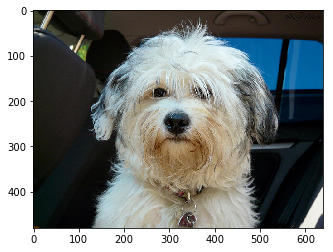

Dog was detected in the image ! Breed: Havanese


In [32]:
# Test 1: Havanese
detector('dogImages/test/082.Havanese/Havanese_05585.jpg')

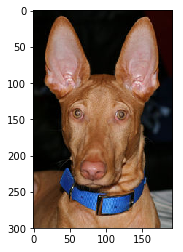

Dog was detected in the image ! Breed: Pharaoh_hound


In [33]:
# Test 2: Pharaoh Hound
detector('dogImages/test/120.Pharaoh_hound/Pharaoh_hound_07728.jpg')

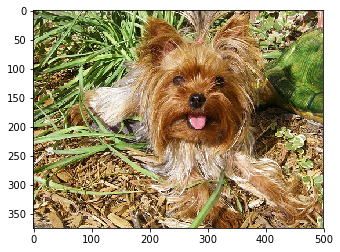

Dog was detected in the image ! Breed: Yorkshire_terrier


In [34]:
# Test 3: Yorkshire terrier
detector('dogImages/test/133.Yorkshire_terrier/Yorkshire_terrier_08325.jpg')

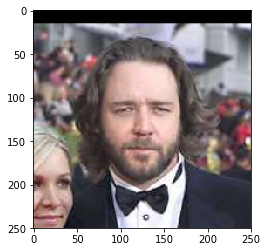

Human was detected in the image ! Most ressemblance with dog breed: English_springer_spaniel


In [36]:
# Test 4: Russell Crowe
detector('lfw/Russell_Crowe/Russell_Crowe_0001.jpg')

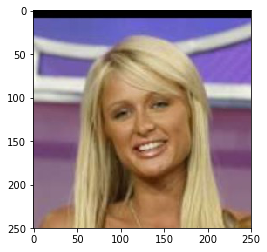

Human was detected in the image ! Most ressemblance with dog breed: Afghan_hound


In [37]:
# Test 5: Paris Hilton
detector('lfw/Paris_Hilton/Paris_Hilton_0001.jpg')

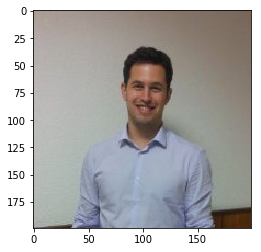

Human was detected in the image ! Most ressemblance with dog breed: Smooth_fox_terrier


In [38]:
# Test 6: myself !
detector('lfw/myself/marshall.jpg')

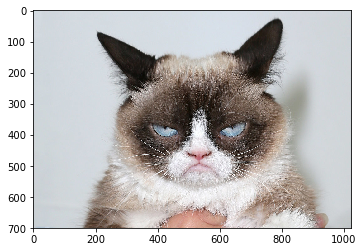

No dogs nor humans detected in this image... Try again !


In [56]:
detector('lfw/myself/grumpy_cat.jpg')